In [23]:
# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [24]:
# Parameters
DATA_DIR = 'Dataset'

VID_DIR = os.path.join(DATA_DIR, 'Videos')

IMG_SIZE = (299, 299)
FRAMES = 10

BATCH_SIZE_VID = 2

EPOCHS_VID = 10

In [25]:
# Custom Video Frame Generator (batch streaming)
def sample_video_frames(video_path, num_frames=FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idxs = np.linspace(0, total - 1, num_frames).astype(int)

    for i in range(total):
        ret, frame = cap.read()
        if not ret:
            break
        if i in idxs:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, IMG_SIZE)
            frames.append(frame / 255.0)
    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])
    return np.array(frames)

def video_generator(video_root, batch_size=BATCH_SIZE_VID):
    classes = ['real', 'fake']
    video_paths, labels = [], []
    for idx, cls in enumerate(classes):
        folder = os.path.join(video_root, cls)
        for f in os.listdir(folder):
            video_paths.append(os.path.join(folder, f))
            labels.append(idx)

    while True:
        idxs = np.random.permutation(len(video_paths))
        for i in range(0, len(idxs), batch_size):
            batch_idx = idxs[i:i+batch_size]
            batch_videos, batch_labels = [], []
            for j in batch_idx:
                try:
                    frames = sample_video_frames(video_paths[j])
                    batch_videos.append(frames)
                    batch_labels.append(labels[j])
                except:
                    continue
            yield np.array(batch_videos, dtype=np.float32), np.array(batch_labels)


In [ ]:

# --------------------------------------------------------------
# Video Model (Xception + LSTM)
frame_cnn = Xception(include_top=False, input_shape=(299, 299, 3), pooling='avg', weights='imagenet')
frame_cnn.trainable = False

model_vid = models.Sequential([
    layers.TimeDistributed(frame_cnn, input_shape=(FRAMES, 299, 299, 3)),
    layers.LSTM(128),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

model_vid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_vid = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    callbacks.ModelCheckpoint('saved_models/best_video_model_xception.h5', save_best_only=True)
]

# --------------------------------------------------------------
# Train Video Model (batch generator)
train_gen_vid = video_generator(os.path.join(VID_DIR), BATCH_SIZE_VID)
val_gen_vid = video_generator(os.path.join(VID_DIR), BATCH_SIZE_VID)

steps_train = sum([len(files) for r, d, files in os.walk(os.path.join(VID_DIR, 'real'))]) // BATCH_SIZE_VID
steps_val = steps_train // 4 

print("\nTraining Xception+LSTM Video Model...")
history_vid = model_vid.fit(
    train_gen_vid,
    validation_data=val_gen_vid,
    steps_per_epoch=steps_train,
    validation_steps=steps_val,
    epochs=EPOCHS_VID,
    callbacks=callbacks_vid,
    verbose=1
)

model_vid.save('saved_models/final_video_deepfake_model_xception.h5')



Training Xception+LSTM Video Model...
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.4044 - loss: 0.7664 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1982s 20s/step - accuracy: 0.4450 - loss: 0.7381 - val_accuracy: 0.4800 - val_loss: 0.6920
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1617s 16s/step - accuracy: 0.4900 - loss: 0.7040 - val_accuracy: 0.4600 - val_loss: 0.6938
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.5097 - loss: 0.6950 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1659s 17s/step - accuracy: 0.5050 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6856
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2516s 25s/step - accuracy: 0.4850 - loss: 0.7142 - val_accuracy: 0.4200 - val_loss: 0.7039
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6055 - loss: 0.6781 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1896s 19s/step - accuracy: 0.6050 - loss: 0.6696 - val_accuracy: 0.7000 - val_loss: 0.6149
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1458s 15s/step - accuracy: 0.5400 - loss: 0.6854 - val_accuracy: 0.5400 - val_loss: 0.6578
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6422 - loss: 0.6508 

100/100 ━━━━━━━━━━━━━━━━━━━━ 1417s 14s/step - accuracy: 0.6600 - loss: 0.6457 - val_accuracy: 0.8000 - val_loss: 0.5423
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1696s 17s/step - accuracy: 0.5950 - loss: 0.6559 - val_accuracy: 0.7000 - val_loss: 0.6094
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1611s 16s/step - accuracy: 0.6450 - loss: 0.5966 - val_accuracy: 0.7400 - val_loss: 0.5461
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1632s 16s/step - accuracy: 0.6350 - loss: 0.6394 - val_accuracy: 0.6800 - val_loss: 0.5606



Evaluating video model...

Starting evaluation...
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━

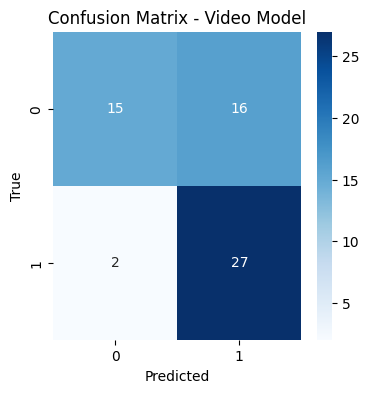


Classification Report (Video Model):
              precision    recall  f1-score   support

    Fake (0)       0.88      0.48      0.62        31
    Real (1)       0.63      0.93      0.75        29

    accuracy                           0.70        60
   macro avg       0.76      0.71      0.69        60
weighted avg       0.76      0.70      0.69        60



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model_vid = load_model("saved_models/final_video_deepfake_model_xception.h5")
val_gen_vid = video_generator(os.path.join(VID_DIR), BATCH_SIZE_VID)

def evaluate_video_model(model, generator, steps=None):
    y_true, y_pred = [], []

    print("\nStarting evaluation...")

    # Safely set steps (if not provided)
    if steps is None:
        try:
            steps = len(generator)
        except TypeError:
            steps = 10  # fallback if it's a generator without len()

    # Iterate through generator
    for i, (X_batch, y_batch) in enumerate(generator):
        preds = (model.predict(X_batch) > 0.5).astype(int)

        # If y_batch is one-hot, convert it
        if y_batch.ndim > 1 and y_batch.shape[-1] > 1:
            y_batch = np.argmax(y_batch, axis=1)

        y_true.extend(y_batch)
        y_pred.extend(preds.flatten())

        # Optional: break after given steps
        if steps and i >= steps - 1:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Video Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    print("\nClassification Report (Video Model):")
    print(classification_report(y_true, y_pred, target_names=['Fake (0)', 'Real (1)']))

# Call the function
print("\nEvaluating video model...")
evaluate_video_model(model_vid, val_gen_vid, steps=30)  # you can increase steps for larger evaluation


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model
model_vid = tf.keras.models.load_model("saved_models/final_video_deepfake_model_xception.h5")

# Label mapping
CLASS_NAMES = {0: "Fake", 1: "Real"}

# Function to preprocess a frame
def preprocess_frame(frame, target_size=(299, 299)):
    frame = cv2.resize(frame, target_size)
    frame = frame.astype("float32") / 255.0
    return frame

# Function to predict a single video
def predict_video(video_path, model, frame_sample_rate=10):
    cap = cv2.VideoCapture(video_path)

    frames = []
    frame_count = 0

    # Read frames from the video
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Sample every Nth frame to save memory
        if frame_count % frame_sample_rate == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = preprocess_frame(frame)
            frames.append(frame)

        frame_count += 1

    cap.release()

    if len(frames) == 0:
        print(" No frames read from video.")
        return None

    frames = np.array(frames)
    frames = np.expand_dims(frames, axis=0)  # Shape: (1, num_frames, H, W, C)

    # Predict
    pred = model.predict(frames)[0][0]

    # label = 1 if pred > 0.5 else 0
    # confidence = pred if label == 1 else 1 - pred
    label = 0 if pred > 0.5 else 1  # flip labels
    confidence = pred if label == 0 else 1 - pred


    print(f"🎥 Prediction: {CLASS_NAMES[label]} ({confidence*100:.2f}% confidence)")
    return CLASS_NAMES[label], float(confidence)

# Example usage
video_path = "Dataset/Videos/real/15__outside_talking_pan_laughing.mp4"  # change this to your video path
predict_video(video_path, model_vid)


1/1 ━━━━━━━━━━━━━━━━━━━━ 85s 85s/step
🎥 Prediction: Real (73.26% confidence)


('Real', 0.7326409220695496)

In [12]:
print(model_vid.layers[-1].get_weights())


[array([[-6.28575012e-02],
       [-2.06666276e-01],
       [-1.61598669e-04],
       [-9.45599601e-02],
       [ 1.03239179e-01],
       [-1.87157333e-01],
       [ 4.61619236e-02],
       [-5.98941837e-03],
       [ 4.43395525e-02],
       [-1.53854117e-01],
       [ 1.39447628e-03],
       [ 5.28368875e-02],
       [ 2.66699586e-02],
       [ 9.32395011e-02],
       [ 9.10559297e-02],
       [ 2.01126352e-01],
       [ 1.38130888e-01],
       [ 1.86126262e-01],
       [-1.44252583e-01],
       [ 1.37753084e-01],
       [-2.99924379e-03],
       [ 1.29937619e-01],
       [-5.00621162e-02],
       [-8.72180238e-02],
       [ 3.16065662e-02],
       [-2.71468842e-03],
       [-8.65861848e-02],
       [ 5.12877554e-02],
       [ 6.83848783e-02],
       [-9.59763527e-02],
       [-1.02292620e-01],
       [-5.75900860e-02],
       [ 1.14152573e-01],
       [-1.70300417e-02],
       [ 2.32614903e-03],
       [ 1.60780668e-01],
       [ 9.51315165e-02],
       [ 5.70479035e-02],
       [ 1.

-ve values shows Fake favoured prediction

In [22]:
print("Model output shape:", model_vid.output_shape)
print("Model Summary",model_vid.summary())

Model output shape: (None, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, 10, 2048)       │    20,861,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │     1,114,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,992,747 (83.90 MB)

 Trainable params: 1,131,265 (4.32 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2 (12.00 B)

Model Summary None
